# **INFO5731 In-class Exercise 4**

**This exercise will provide a valuable learning experience in working with text data and extracting features using various topic modeling algorithms. Key concepts such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA), lda2vec, and BERTopic.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## Question 1 (10 Points)

**Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.1 which is incompatible.


In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import nltk
nltk.download('stopwords')


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# New text data
new_text = [
"I love the design, the size and feel of Alexa.",
"The sound is adequate for my night music needs.",
"The voice recognition is poor, making me repeat Alexa often.",
"I will have to talk to the nice amazon techies soon."
]

# Convert the new text data to a list
data = new_text

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data)

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words)

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized)

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus)

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['I love the design, the size and feel of Alexa.',
 'The sound is adequate for my night music needs.',
 'The voice recognition is poor, making me repeat Alexa often.',
 'I will have to talk to the nice amazon techies soon.']
[['love', 'the', 'design', 'the', 'size', 'and', 'feel', 'of', 'alexa'], ['the', 'sound', 'is', 'adequate', 'for', 'my', 'night', 'music', 'needs'], ['the', 'voice', 'recognition', 'is', 'poor', 'making', 'me', 'repeat', 'alexa', 'often'], ['will', 'have', 'to', 'talk', 'to', 'the', 'nice', 'amazon', 'techies', 'soon']]
[['love', 'design', 'size', 'feel', 'alexa'], ['sound', 'adequate', 'night', 'music', 'need'], ['voice', 'recognition', 'poor', 'making', 'repeat', 'alexa', 'often'], ['talk', 'nice', 'amazon', 'techie', 'soon']]
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [(5, 1), (6, 1), (7, 1), (8, 1), (9, 1)], [(0, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)], [(16, 1), (17, 1), (18, 1), (19, 1), (20, 1)]]
[(0,
  '0.048*"often" + 0.048*"making" + 0.0

## Question 2 (10 Points)

**Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

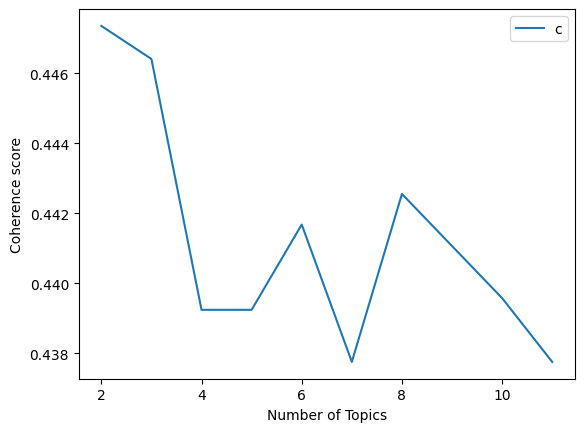

[(0, '-0.480*"alexa" + -0.339*"often" + -0.339*"voic" + -0.339*"repeat" + -0.339*"recognit" + -0.339*"poor" + -0.339*"make" + -0.141*"feel" + -0.141*"design" + -0.141*"size"'), (1, '0.424*"techi" + 0.424*"nice" + 0.424*"soon" + 0.424*"talk" + 0.424*"amazon" + -0.141*"night" + -0.141*"music" + -0.141*"need" + -0.141*"sound" + -0.141*"adequ"'), (2, '0.424*"night" + 0.424*"adequ" + 0.424*"music" + 0.424*"need" + 0.424*"sound" + 0.141*"amazon" + 0.141*"soon" + 0.141*"nice" + 0.141*"talk" + 0.141*"techi"'), (3, '-0.431*"love" + -0.431*"feel" + -0.431*"size" + -0.431*"design" + -0.253*"alexa" + 0.179*"voic" + 0.179*"repeat" + 0.179*"recognit" + 0.179*"poor" + 0.179*"often"')]


In [6]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

def preprocess_data(doc_set):
    """
    Input  : document list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = set(stopwords.words('english'))
    p_stemmer = PorterStemmer()
    texts = []
    for i in doc_set:
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [i for i in tokens if not i in en_stop]
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        texts.append(stemmed_tokens)
    return texts

def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index.
    dictionary = corpora.Dictionary(doc_clean)

    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

    return dictionary, doc_term_matrix

def create_gensim_lsa_model(doc_clean, number_of_topics, words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word=dictionary)
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean, start, stop, step):
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start, step)
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

# Commentary data
commentary = [
"I love the design, the size and feel of Alexa.",
"The sound is adequate for my night music needs.",
"The voice recognition is poor, making me repeat Alexa often.",
"I will have to talk to the nice amazon techies soon."
]

# Preprocess the commentary data
clean_commentary = preprocess_data(commentary)

# Plot the coherence graph
start, stop, step = 2, 12, 1
plot_graph(clean_commentary, start, stop, step)

# LSA Model
number_of_topics = 7
words = 10
model = create_gensim_lsa_model(clean_commentary, number_of_topics, words)

## Question 3 (10 points):
**Generate K topics by using lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

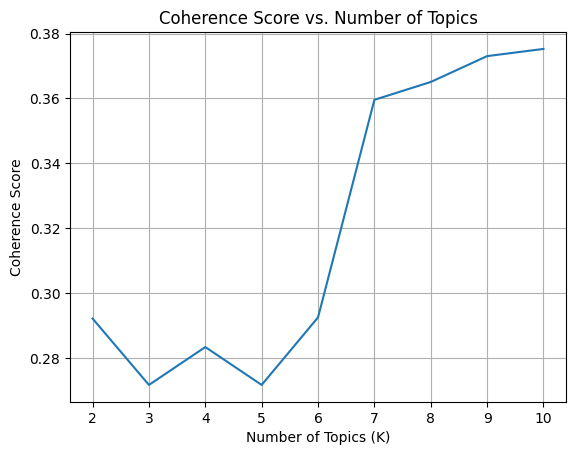

Optimal Number of Topics (K): 10
Topic 0: 0.030*"the" + 0.030*"i" + 0.030*"is" + 0.030*"techies" + 0.030*"and" + 0.030*"for" + 0.030*"often." + 0.030*"night" + 0.030*"repeat" + 0.030*"to"
Topic 1: 0.147*"to" + 0.077*"soon." + 0.077*"amazon" + 0.077*"nice" + 0.077*"talk" + 0.077*"will" + 0.077*"have" + 0.077*"techies" + 0.077*"i" + 0.077*"the"
Topic 2: 0.030*"the" + 0.030*"music" + 0.030*"is" + 0.030*"night" + 0.030*"to" + 0.030*"i" + 0.030*"and" + 0.030*"talk" + 0.030*"techies" + 0.030*"alexa"
Topic 3: 0.083*"recognition" + 0.083*"alexa" + 0.083*"making" + 0.083*"me" + 0.083*"voice" + 0.083*"poor," + 0.083*"often." + 0.083*"repeat" + 0.083*"is" + 0.083*"the"
Topic 4: 0.089*"is" + 0.089*"adequate" + 0.089*"my" + 0.089*"for" + 0.089*"sound" + 0.089*"needs." + 0.089*"night" + 0.089*"music" + 0.089*"the" + 0.008*"i"
Topic 5: 0.158*"the" + 0.083*"i" + 0.083*"love" + 0.083*"feel" + 0.083*"size" + 0.083*"of" + 0.083*"alexa." + 0.083*"and" + 0.083*"design," + 0.008*"is"
Topic 6: 0.030*"the" + 

In [44]:
from gensim import corpora, models
import matplotlib.pyplot as plt
import numpy as np
import pyLDAvis

try:
    import seaborn
except ImportError:
    pass

pyLDAvis.enable_notebook()

# Sample text data
texts = [
"I love the design, the size and feel of Alexa.",
"The sound is adequate for my night music needs.",
"The voice recognition is poor, making me repeat Alexa often.",
"I will have to talk to the nice amazon techies soon."
]

# Tokenize and preprocess text data
tokenized_text = [text.lower().split() for text in texts]

# Create dictionary and corpus
dictionary = corpora.Dictionary(tokenized_text)
corpus = [dictionary.doc2bow(text) for text in tokenized_text]

# Function to compute coherence score for a given LDA model
def compute_coherence_score(corpus, dictionary, k):
    lda_model = models.LdaModel(corpus, id2word=dictionary, num_topics=k, passes=10)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_text, dictionary=dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()

# Determine the optimal number of topics based on coherence score
min_topics = 2
max_topics = 10
step = 1
coherence_scores = []
for k in range(min_topics, max_topics + 1, step):
    coherence_score = compute_coherence_score(corpus, dictionary, k)
    coherence_scores.append(coherence_score)

# Plot coherence scores
plt.plot(range(min_topics, max_topics + 1, step), coherence_scores)
plt.xlabel("Number of Topics (K)")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.grid(True)
plt.show()

# Select the optimal number of topics (K)
optimal_k = coherence_scores.index(max(coherence_scores)) + min_topics
print("Optimal Number of Topics (K):", optimal_k)

# Train the final LDA model with the optimal number of topics
final_lda_model = models.LdaModel(corpus, id2word=dictionary, num_topics=optimal_k, passes=10)

# Extract and summarize topics from the final model
final_topics = final_lda_model.print_topics(num_words=10)
for topic in final_topics:
    print("Topic {}: {}".format(topic[0], topic[1]))





## Question 4 (10 points):
**Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [17]:
%%capture
!pip install bertopic

In [18]:
from sklearn.datasets import fetch_20newsgroups
docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']

In [19]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/589 [00:00<?, ?it/s]

In [20]:

freq = topic_model.get_topic_info(); freq.head(5)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,6300,-1_to_the_of_is,"[to, the, of, is, and, in, for, you, it, that]","[First, I would like to thank all who sent me ..."
1,0,1838,0_game_team_games_he,"[game, team, games, he, players, season, hocke...","[Apparently, Part 2 (defensemen numbered 2 thr..."
2,1,596,1_key_clipper_chip_encryption,"[key, clipper, chip, encryption, keys, escrow,...",[Here is a revised version of my summary which...
3,2,488,2_ites_yep_dir_huh,"[ites, yep, dir, huh, ken, forget, art, lets, ...","[\nHuh?, ites:, dir\n]"
4,3,456,3_drive_scsi_drives_ide,"[drive, scsi, drives, ide, disk, controller, h...",[Computer Equipment Garage Sale:\n\nI've final...


In [21]:
topic_model.get_topic(0)  # Select the most frequent topic

[('game', 0.010333801056221644),
 ('team', 0.009011699766515432),
 ('games', 0.007171646637749217),
 ('he', 0.007064644597177547),
 ('players', 0.006326423974112478),
 ('season', 0.006233086058545059),
 ('hockey', 0.006109747026550908),
 ('play', 0.005767654668038669),
 ('25', 0.005632756786011058),
 ('year', 0.0056036766821941295)]

In [22]:
topic_model.topics_[:10]

[0, 47, 21, 3, 85, -1, -1, 0, 0, -1]

In [23]:
topic_model.visualize_topics()

In [24]:
topic_model.visualize_distribution(probs[200], min_probability=0.015)

In [25]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [26]:
topic_model.visualize_barchart(top_n_topics=5)

In [27]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

In [28]:
topic_model.visualize_term_rank()

In [29]:
topic_model.update_topics(docs, n_gram_range=(1, 2))

In [30]:
topic_model.get_topic(0)   # We select topic that we viewed before

[('game', 0.006559196212334037),
 ('team', 0.005612858084706257),
 ('he', 0.005301436186065957),
 ('games', 0.004422294854711107),
 ('the', 0.003994295609640917),
 ('players', 0.0038064639798928773),
 ('was', 0.0037824736530586937),
 ('season', 0.0037487709634896386),
 ('hockey', 0.0036644700305778787),
 ('year', 0.0036174661270427884)]

In [31]:
topic_model.reduce_topics(docs, nr_topics=60)

In [32]:
# Access the newly updated topics with:
print(topic_model.topics_)

[0, 0, 14, 0, 34, -1, -1, 0, 0, -1, -1, -1, -1, 0, -1, 14, 0, 3, 9, 2, 2, -1, -1, 2, 0, 8, 3, -1, -1, -1, 2, 3, 0, 0, 7, 12, 33, 19, 2, -1, 0, 0, 10, -1, 0, -1, -1, 0, 4, 7, -1, 2, 3, 4, 19, 39, -1, -1, 1, 4, 0, -1, -1, -1, -1, 0, 0, -1, -1, -1, -1, -1, 0, -1, -1, -1, 0, 0, -1, 0, 23, 2, -1, 10, 13, -1, -1, 3, -1, 31, 0, 6, 1, 0, 14, 0, -1, -1, 3, -1, 48, -1, -1, 5, 6, 0, -1, -1, -1, -1, 12, 10, 8, 0, 14, 1, -1, 0, 0, 0, 0, 10, -1, -1, 28, -1, -1, 6, -1, -1, 3, -1, -1, 0, 0, 6, 0, 4, 0, -1, -1, 12, 15, 0, 19, -1, 12, 0, 0, -1, 2, 2, 0, -1, 35, -1, -1, 5, 8, 0, -1, 6, -1, -1, -1, -1, 1, 0, 0, 7, 13, -1, 0, -1, 7, -1, 0, -1, 2, 0, 2, 0, 11, -1, -1, 6, -1, -1, 14, -1, 0, -1, 6, 1, 1, 1, 14, -1, -1, -1, -1, -1, 5, -1, -1, -1, 7, -1, 0, 1, -1, 0, -1, 0, 2, 3, -1, -1, -1, 6, 0, 1, 0, 2, 4, -1, 4, 2, -1, 0, -1, -1, -1, -1, 0, -1, 1, 0, 0, 0, 10, 10, 7, -1, -1, 0, 30, 2, 1, 5, 0, 45, 17, -1, -1, 0, 16, -1, 0, -1, 10, 10, 8, -1, 0, 0, 0, -1, -1, 0, 0, -1, 30, -1, 7, -1, 14, -1, 0, 1, 7, 1, -1, 

In [33]:
similar_topics, similarity = topic_model.find_topics("vehicle", top_n=5); similar_topics

[2, 10, 0, 19, 8]

In [34]:
topic_model.get_topic(71)

False

In [35]:
# Save model
topic_model.save("my_model")

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [36]:
# Load model
my_model = BERTopic.load("my_model")

In [37]:
topic_model = BERTopic(embedding_model="xlm-r-bert-base-nli-stsb-mean-tokens")

In [38]:
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer("distilbert-base-nli-mean-tokens", device="cpu")
topic_model = BERTopic(embedding_model=sentence_model, verbose=True)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Extra Question (5 Points)

**Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.**

**This question will compensate for any points deducted in this exercise. Maximum marks for the exercise is 40 points.**

Comparing the results of Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA), lda2vec, and BERTopic for topic modeling presents a nuanced evaluation that considers several key factors. LDA, a probabilistic modeling approach, excels in providing interpretable topics by modeling documents as a mixture of topics with Dirichlet priors. However, LDA's performance heavily relies on the correct choice of hyperparameters, including the number of topics, which can impact the quality of the topics extracted. LSA, on the other hand, offers simplicity and scalability, but it may struggle with capturing nuanced semantic relationships in text data compared to more probabilistic methods like LDA. LDA2Vec combines the strengths of both LDA and word embeddings by jointly training topic vectors and word vectors, enhancing interpretability and capturing semantic relationships. However, it requires careful tuning of hyperparameters and may suffer from scalability issues with large datasets. BERTopic leverages pre-trained BERT embeddings to cluster documents into topics based on semantic similarity, offering adaptability across domains and languages without the need for specifying the number of topics. However, BERTopic's topics may be less interpretable due to the complexity of BERT embeddings and may require post-processing for better understanding. Overall, the choice of the best topic modeling algorithm depends on specific requirements such as interpretability, scalability, adaptability, and computational resources. For scenarios where interpretability is paramount and the dataset is not excessively large, LDA or LDA2Vec may be preferable. Conversely, when scalability and adaptability are crucial, BERTopic might be the better choice. Nevertheless, a comprehensive evaluation considering these factors is essential to determine the most suitable algorithm for a given task.

# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.

Consider the following points in your response:

**Learning Experience:** Describe your overall learning experience in working with text data and extracting features using various topic modeling algorithms. Did you understand these algorithms and did the implementations helped in grasping the nuances of feature extraction from text data.

**Challenges Encountered:** Were there specific difficulties in completing this exercise?

Relevance to Your Field of Study: How does this exercise relate to the field of NLP?

**(Your submission will not be graded if this question is left unanswered)**



In [ ]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
The entire exercise is bit tough. The generating the topics through the bert model is difficult.



'''